In [1]:
import pandas as pd
import numpy as np
import scipy
import scipy.io as sio
import math
import warnings
import warnings
import time
from itertools import combinations
from itertools import product

from numpy import linalg as LA
import statsmodels.api as sm
from scipy.stats import nbinom
from scipy import stats
from scipy import optimize
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score

from scipy.stats import norm
from scipy import signal
# from open_ephys.analysis import Session
from pathlib import Path
import glob
import os
from os import listdir

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits import mplot3d
# from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

sz1 = 10
sz2 = 20
sns.set(style="ticks", rc={"lines.linewidth": 1})
matplotlib.rc('xtick', labelsize=sz1) 
matplotlib.rc('ytick', labelsize=sz1) 
matplotlib.rc('axes', labelsize=sz1)  
matplotlib.rc('axes', titlesize=sz1)  
matplotlib.rc('figure', titlesize=sz2)
matplotlib.rc('legend', fontsize=sz1) 
matplotlib.rc('legend', title_fontsize=sz1)
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

In [2]:
variables = ['Goal','CurrentState','ChosenState','Distance','ChosenLocation','Choice','IsGoal','Subgraph','ChosenSubgraph']
epochs = ['DelayperiodEntry','FeedbackPeriodEntry']

goal_dict = dict(zip([1,3,5,6,8,10],['A1','A3','A5','B1','B3','B5']))
curr_dict = dict(zip([2,3,4,7,8,9,11,12,13],['A2','A3','A4','B2','B3','B4','C2','C3','C4']))
chosen_dict = dict(zip(np.arange(1,14),['A1','A2','A3','A4','A5','B1','B2','B3','B4','B5','C2','C3','C4']))
distance_dict = dict(zip(np.arange(1,9),np.arange(1,9)))
loc_dict = dict(zip(np.arange(200,800,200),['left','top','right']))
choice_dict = dict(zip([0,1],['Incorrect','Correct']))
goal_dict = dict(zip([0,1],['Non-Goal','Goal']))
sub_dict = dict(zip([0,1,2],['A','B','C']))

variable_dict = pd.DataFrame(data={'col1': variables, 
                           'col2': pd.Series([goal_dict,curr_dict,chosen_dict,distance_dict,loc_dict,
                                              choice_dict,goal_dict,sub_dict,sub_dict])})

In [3]:
def load_data(DATA_DIRECTORY):
    
    # load sorted spikes and behavior
    
    ks_folder = DATA_DIRECTORY / 'kilosort4' 
    spikes = np.load(ks_folder / 'spike_times.npy')   # spikes from kilosort output is the # sample
    clusters = np.load(ks_folder / 'spike_clusters.npy')
    
    # load OE timestamps
    session = Session(DATA_DIRECTORY)
    recording = session.recordnodes[0].recordings[0]
    timestamps = recording.continuous[0].timestamps
    
    align_file = open(DATA_DIRECTORY / 'Record Node 113/experiment1/recording1/alignmentinfo_README.txt', "r")
    align_info = align_file.readlines()
    
    A = float(align_info[1][3:-1])
    B = float(align_info[0][3:-1])
    
    # aligned to behavior
    timestamps_aligned = timestamps*A+B
    
    # assign behavior aligned timestamps to each spike
    spikes_ts = timestamps_aligned[spikes]

    # load behavior data
    os.chdir(DATA_DIRECTORY)
    for filepath in glob.glob('*.beh.txt'):
        beh = pd.read_csv(filepath, sep=",")
        beh.reset_index(drop=True, inplace=True)

    beh = beh[beh.ITIEntry.values/1000<spikes_ts[-1]]
    beh['FirstStep']=beh['CompletedNum']==1
    beh['IsGoal']=beh['Goal']==beh['ChosenState']
    
    return clusters,spikes_ts,beh

In [4]:
def FR_matrix(data,spikes_ts,clusters,epochs,window=[-1,1],sigma=50,step=10,normalize=1):
    
    dur = (spikes_ts[-1]-spikes_ts[0])

    # gaussian kernel
    gx = np.arange(-3*sigma, 3*sigma)
    gaussian = np.exp(-(gx/sigma)**2/2)/(sigma*np.sqrt(2*np.pi))
    
    FR = np.zeros((len(data),len(np.unique(clusters)),len(epochs),int((window[1]-window[0])*1000/step+1)))
    
    for cellid in np.unique(clusters):

        mean_FR = np.sum(clusters==cellid)/dur
    
        if mean_FR>0.1:

            cell_spike = spikes_ts[clusters==cellid]
    
            for ii,epoch in enumerate(epochs):
    
                timestamps = data[epoch].to_numpy().astype(float)/1000+data['GlobalStart'].iloc[0]
                    
                for trial in range(len(data)): 
                    
                    ind = (cell_spike>timestamps[trial]+window[0]-0.5) & (cell_spike<(timestamps[trial]+window[1]+0.5))
                    trial_spike = cell_spike[ind]-timestamps[trial]
                    binned_spikes,_ = np.histogram(trial_spike,np.linspace(window[0]-0.5,window[1]+0.5,int((window[1]-window[0])*1000+1001)))
                    sdf = np.convolve(binned_spikes, gaussian, mode='same')[500:-500+step:step]
                    FR[trial,cellid,ii,:] = sdf*1000

    FR = FR.reshape((len(data),len(np.unique(clusters)),-1))
    FR = FR[:,FR.mean(axis=(0,2))>0,:]

    if normalize == 1:
        FR = (FR-np.tile(FR.mean(axis=(0,2),keepdims=True),(len(data),1,402)))/np.tile(FR.std(axis=(0,2),keepdims=True),(len(data),1,402))
    
    return FR

In [5]:
mypath = Path('D:/HexinData')
AllData = pd.DataFrame()
AllFR = []

for ii,f in enumerate(listdir(mypath)):
    
    DATA_DIRECTORY = mypath / f

    if os.path.isdir(DATA_DIRECTORY):
        
        print(DATA_DIRECTORY)
        
        clusters,spikes_ts,beh = load_data(DATA_DIRECTORY)
        # FR_all[ii] = construct_FR_matrix(beh,spikes_ts,clusters,epochs)
        FR = FR_matrix(beh,spikes_ts,clusters,epochs)
        AllData = pd.concat([AllData,beh])
        AllFR.append(FR)
        
AllData['Subgraph']=(AllData.CurrentState.values-1)//5
AllData.to_csv('D:\HexinData\AllData.csv',index = False)
np.save('D:/HexinData/FiringRates.npy',np.array(AllFR, dtype=object), allow_pickle=True)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'D:\\HexinData'

In [6]:
# load all data
AllsesFR = np.load('FiringRates.npy', allow_pickle=True)
AllData = pd.read_csv('AllData.csv')
AllsesFR_list=[]
for x in range(len(AllsesFR)):
    AllsesFR_list.extend(list(AllsesFR[x]))
AllData['Neural'] = AllsesFR_list

In [7]:
indices = np.concatenate([[0],np.where(np.diff(AllData.TotalEpisodeNum)<0)[0]+1])
indices = np.concatenate([indices,[len(AllData)]])
sesNum=np.array([])
for ii in range(len(AllsesFR)):
    sesNum = np.concatenate([sesNum,np.ones(indices[ii+1]-indices[ii])*ii])
AllData['SessionNum']=sesNum

In [8]:
AllData['Subgraph']=(AllData.CurrentState.values-1)//5

In [9]:
AllData['ChosenSubgraph']=(AllData.ChosenState.values-1)//5

In [56]:
for var in ['ChosenState']:
    
    colors = sns.color_palette('Set1')
    
    if var=='Goal' or var=='CurrentState' or var=='ChosenState':
        colors = list(sns.color_palette('Purples',5))+list(sns.color_palette('Greens',5))+list(sns.color_palette('Reds',3))
    
    if var=='Distance':
        colors = sns.color_palette('Purples_r',8)

    if var=='Subgraph' or var=='ChosenSubgraph':
        colors = list(sns.color_palette('Purples',1))+list(sns.color_palette('Greens',1))+list(sns.color_palette('Reds',1))
    
    keys = np.array(list(variable_dict[variable_dict.col1==var].col2.values[0].keys()))
    
    for ss in AllData.SessionNum.unique():
    
        sesData = AllData[(AllData.SessionNum==ss) & (AllData.Control==0)]
        FR = np.concatenate(sesData['Neural'].values).reshape((len(sesData),-1,402))
        spikes_sorted = np.zeros((FR.shape[1],len(keys),402))
            
        for ii,vv in enumerate(keys):
    
            ind = sesData[var].values==vv
        
            if ind.sum()>10:
                spikes_sorted[:,ii,:] = FR[ind,:,:].mean(axis=0)
            else:
                print(vv)
    
        if ss==0:
            AllFR = spikes_sorted
        else:
            AllFR = np.concatenate([AllFR,spikes_sorted],axis=0)
            
AllFR = AllFR[:,:,50:-50]

In [57]:
# centered_FR = AllFR - np.tile(AllFR.mean(axis=1,keepdims=True),(1,len(keys),1))
centered_FR = AllFR
# centered_FR = centered_FR - np.tile(centered_FR.mean(axis=1,keepdims=True),(1,6,1))
n_com = 3
pca = PCA(n_components=n_com)
pop_pca = pca.fit_transform(centered_FR.reshape(centered_FR.shape[0],-1).T).reshape(( -1, centered_FR.shape[2],  n_com))

In [44]:
sz1 = 20
sz2 = 40
sns.set(style="ticks", rc={"lines.linewidth": 1})
matplotlib.rc('xtick', labelsize=sz1) 
matplotlib.rc('ytick', labelsize=sz1) 
matplotlib.rc('axes', labelsize=sz1)  
matplotlib.rc('axes', titlesize=sz1)  
matplotlib.rc('figure', titlesize=sz2)
matplotlib.rc('legend', fontsize=sz1) 
matplotlib.rc('legend', title_fontsize=sz1)
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

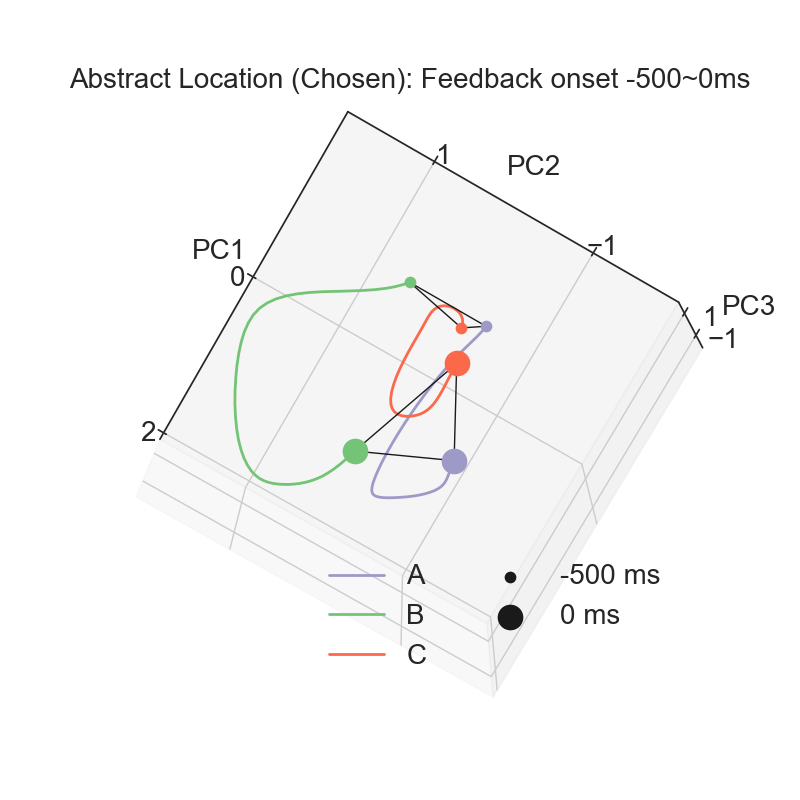

In [121]:
plt.close('all')
ax = plt.figure(figsize=(8,8)).add_subplot(projection='3d')

for ii,vv in enumerate(keys):
#     ax.plot(pop_pca[ii,151:201,0],pop_pca[ii,151:201,1],pop_pca[ii,151:201,2],
#             lw=2,color=colors[ii],
#             label=variable_dict[variable_dict.col1==var].col2.values[0][vv])
    ax.plot(pop_pca[ii,201:251,0],pop_pca[ii,201:251,1],pop_pca[ii,201:251,2],
            lw=2,color=colors[ii],
            label=variable_dict[variable_dict.col1==var].col2.values[0][vv])
    for tt in range(201,301,50):
        ax.scatter(pop_pca[ii,tt,0],pop_pca[ii,tt,1],
                pop_pca[ii,tt,2],s=(tt-190)*5,color=colors[ii])
        
for tt in range(201,301,50):
    ax.plot(pop_pca[[0,1],tt,0],pop_pca[[0,1],tt,1],
            pop_pca[[0,1],tt,2],'k-',lw=1)
    ax.plot(pop_pca[[0,2],tt,0],pop_pca[[0,2],tt,1],
            pop_pca[[0,2],tt,2],'k-',lw=1)
    ax.plot(pop_pca[[2,1],tt,0],pop_pca[[2,1],tt,1],
            pop_pca[[2,1],tt,2],'k-',lw=1)
    
ax.view_init(elev=-80, azim=150)
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_zlim(-2,2)
ax.set_xticks([0,2])
ax.set_yticks([-1,1])
ax.set_zticks([-1,1])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
for tt in range(201,301,50):
    ax.scatter(10,10,10,s=(tt-190)*5,color='k',label=str((tt-251)*10)+' ms')
plt.legend(frameon=False,ncol=2,loc=(0.35,0.05))
plt.title('Abstract Location (Chosen): Feedback onset -500~0ms')
plt.savefig('PCA Chosen Subgraph Location.png',format = 'png')

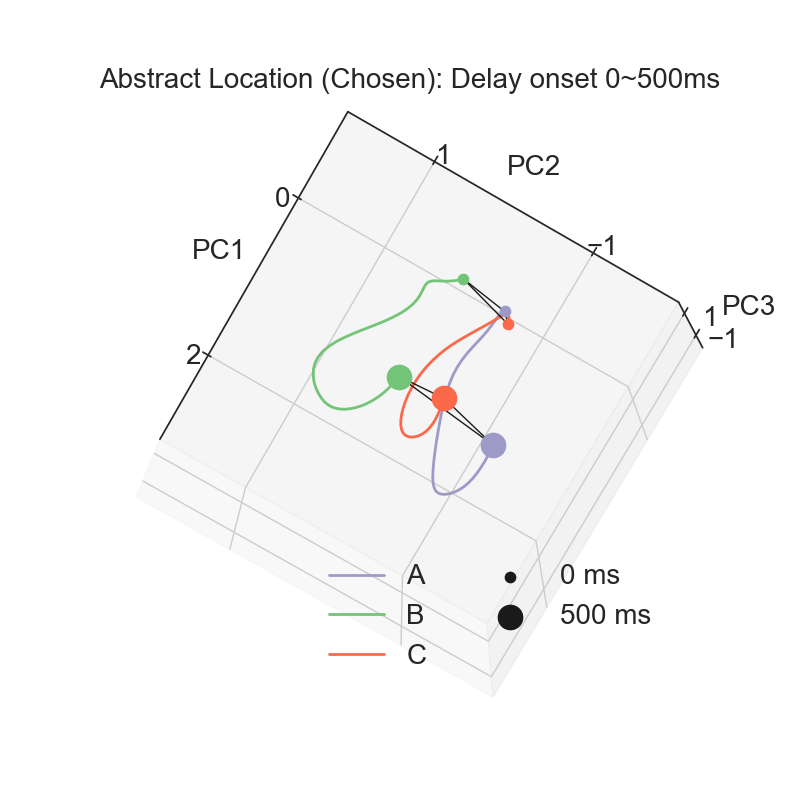

In [122]:
plt.close('all')
ax = plt.figure(figsize=(8,8)).add_subplot(projection='3d')

for ii,vv in enumerate(keys):
    ax.plot(pop_pca[ii,51:101,0],pop_pca[ii,51:101,1],pop_pca[ii,51:101,2],
            lw=2,color=colors[ii],
            label=variable_dict[variable_dict.col1==var].col2.values[0][vv])

    for tt in range(51,151,50):
        ax.scatter(pop_pca[ii,tt,0],pop_pca[ii,tt,1],
                pop_pca[ii,tt,2],s=(tt-40)*5,color=colors[ii])
        
for tt in range(51,151,50):
    ax.plot(pop_pca[[0,1],tt,0],pop_pca[[0,1],tt,1],
            pop_pca[[0,1],tt,2],'k-',lw=1)
    ax.plot(pop_pca[[0,2],tt,0],pop_pca[[0,2],tt,1],
            pop_pca[[0,2],tt,2],'k-',lw=1)
    ax.plot(pop_pca[[2,1],tt,0],pop_pca[[2,1],tt,1],
            pop_pca[[2,1],tt,2],'k-',lw=1)
    
ax.view_init(elev=-80, azim=150)
ax.set_xlim(-1,3)
ax.set_ylim(-2,2)
ax.set_zlim(-2,2)
ax.set_xticks([0,2])
ax.set_yticks([-1,1])
ax.set_zticks([-1,1])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
for tt in range(51,151,50):
    ax.scatter(10,10,10,s=(tt-40)*5,color='k',label=str((tt-51)*10)+' ms')
plt.legend(frameon=False,ncol=2,loc=(0.35,0.05))
plt.title('Abstract Location (Chosen): Delay onset 0~500ms')
plt.savefig('PCA Chosen Subgraph Location Delay onset.png',format = 'png')

Text(0.5, 1.0, 'Chosen State')

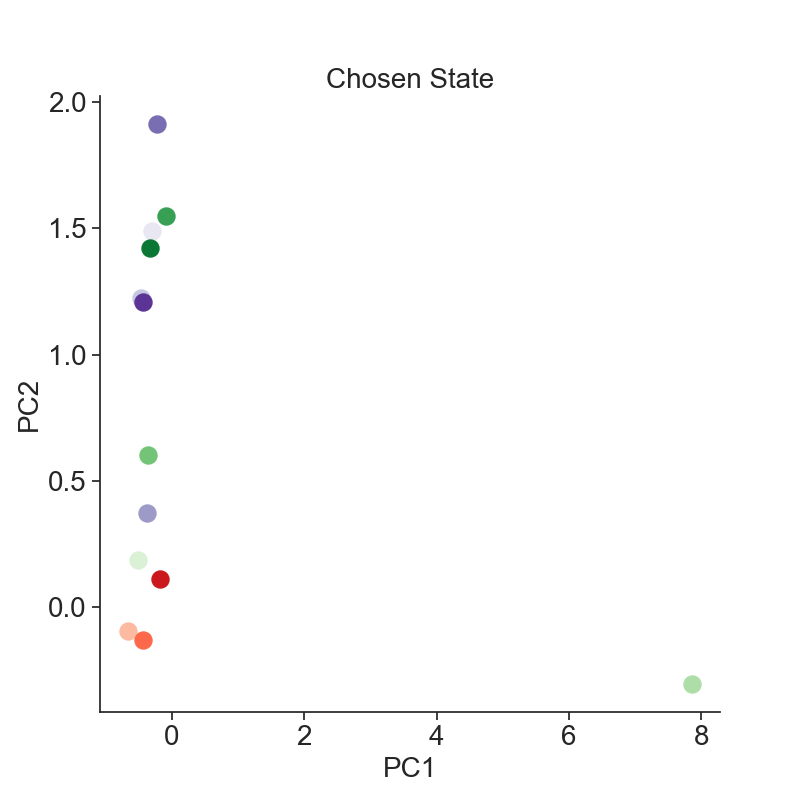

In [69]:
plt.close('all')
plt.figure(figsize=(8,8))

for ii,vv in enumerate(keys):
    plt.scatter(pop_pca[ii,226,0],pop_pca[ii,226,1],
            s=150,color=colors[vv-1],
              label=variable_dict[variable_dict.col1==var].col2.values[0][vv])
    
plt.xlabel('PC1')
plt.ylabel('PC2')
# plt.xlim(-3,3)
# plt.ylim(-2,4)
# plt.xticks([-2,0,2])
# plt.yticks([-2,0,2])
# plt.legend(frameon=False,ncol=3,loc=(0.25,0.78))
plt.title('Chosen State')
# plt.savefig('PCA chosen state 2d.png',format = 'png')

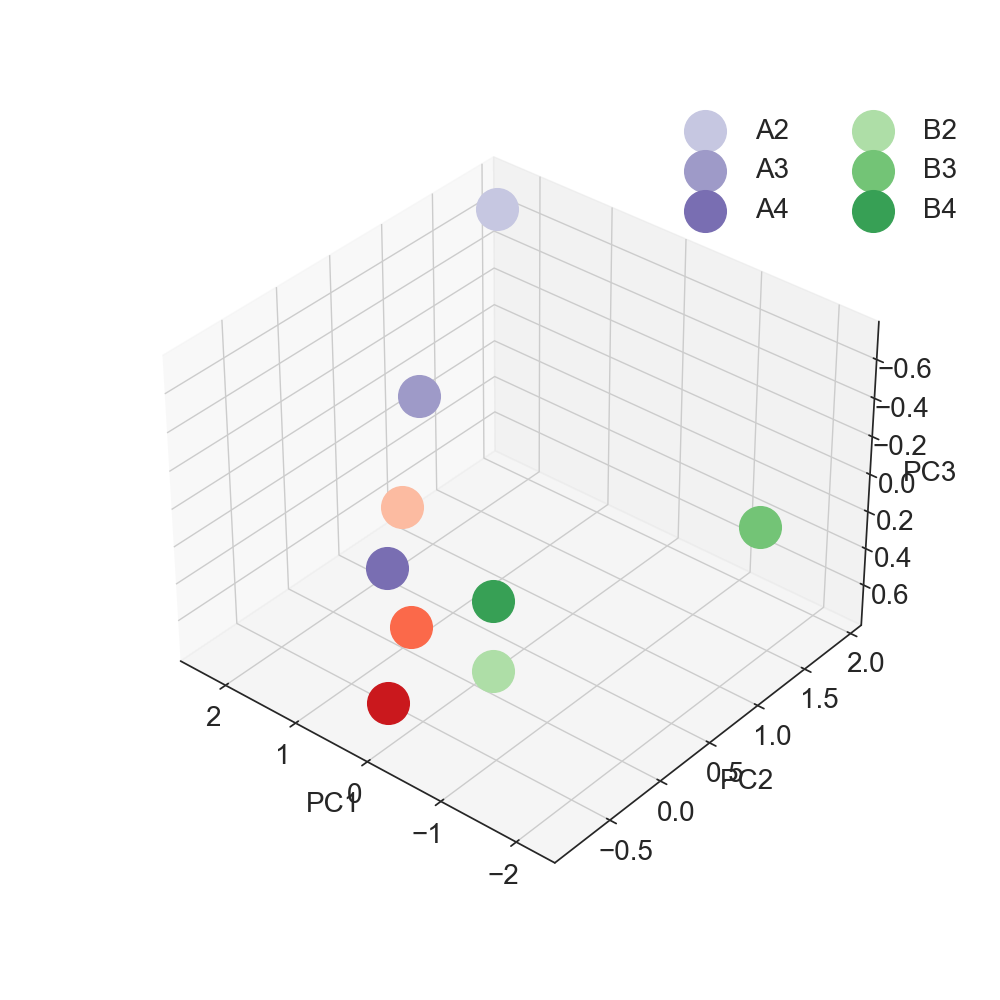

In [241]:
plt.close('all')
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')

for ii,vv in enumerate(keys):
    ax.scatter(pop_pca[ii,85,0],pop_pca[ii,85,1],
            pop_pca[ii,85,2],s=(tt-40)*20,color=colors[vv-1],
              label=variable_dict[variable_dict.col1==var].col2.values[0][vv])

    
ax.view_init(elev=-145, azim=50)
# ax.set_xlim(-1,3)
# ax.set_ylim(-2,2)
# ax.set_zlim(-2,2)
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_zticks([])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.legend(frameon=False,ncol=3,loc=(0.7,0.85))
plt.savefig('PCA current state.png',format = 'png')

In [10]:
kf = KFold(n_splits=2, shuffle=True)
clf = SVC(kernel='linear',probability=True)

In [39]:
ss=5

In [40]:
rep = 4

for var in ['Subgraph']:
    
    keys = np.array(list(variable_dict[variable_dict.col1==var].col2.values[0].keys()))
        
    sesData = AllData[(AllData.SessionNum==ss) & (AllData.Control==0)]
    FR = np.concatenate(sesData['Neural'].values).reshape((len(sesData),-1,402))
    spikes_sorted = np.zeros((FR.shape[1],len(keys),FR.shape[2]))

    accuracy = np.zeros((rep,FR.shape[2]))

    for rr in range(rep):

        print(rr)

        for ii,vv in enumerate(keys):

            conditioned_beh = sesData[sesData[var].values==vv]
            trialNum = np.array(conditioned_beh.index)
            train_ind, test_ind = list(kf.split(trialNum))[0]
            FR = np.stack(conditioned_beh['Neural'].values)

            if ii==0:
                train_X = FR[train_ind,:,:]
                test_X = FR[test_ind,:,:]
                train_Y = np.ones(len(train_ind))*vv
                test_Y = np.ones(len(test_ind))*vv       
            else: 
                train_X = np.concatenate([train_X, FR[train_ind,:,:]])
                test_X = np.concatenate([test_X, FR[test_ind,:,:]])
                train_Y = np.concatenate([train_Y, np.ones(len(train_ind))*vv])
                test_Y = np.concatenate([test_Y, np.ones(len(test_ind))*vv])

        for t in range(FR.shape[2]):
            clf.fit(train_X[:,:,t],train_Y)
            accuracy[rr,t] = balanced_accuracy_score(test_Y,clf.predict(test_X[:,:,t]))


0
1
2
3


In [41]:
rep = 4

for var in ['ChosenSubgraph']:
    
    keys = np.array(list(variable_dict[variable_dict.col1==var].col2.values[0].keys()))

    sesData = AllData[(AllData.SessionNum==ss) & (AllData.Control==0)]
    FR = np.concatenate(sesData['Neural'].values).reshape((len(sesData),-1,402))
    spikes_sorted = np.zeros((FR.shape[1],len(keys),FR.shape[2]))

    chosen_accuracy = np.zeros((rep,FR.shape[2]))

    for rr in range(rep):

        print(rr)

        for ii,vv in enumerate(keys):

            conditioned_beh = sesData[sesData[var].values==vv]
            trialNum = np.array(conditioned_beh.index)
            train_ind, test_ind = list(kf.split(trialNum))[0]
            FR = np.stack(conditioned_beh['Neural'].values) #[:,:,np.hstack([np.arange(0,201,5),np.arange(201,402,5)])]

            if ii==0:
                train_X = FR[train_ind,:,:]
                test_X = FR[test_ind,:,:]
                train_Y = np.ones(len(train_ind))*vv
                test_Y = np.ones(len(test_ind))*vv       
            else: 
                train_X = np.concatenate([train_X, FR[train_ind,:,:]])
                test_X = np.concatenate([test_X, FR[test_ind,:,:]])
                train_Y = np.concatenate([train_Y, np.ones(len(train_ind))*vv])
                test_Y = np.concatenate([test_Y, np.ones(len(test_ind))*vv])

        for t in range(FR.shape[2]):
            clf.fit(train_X[:,:,t],train_Y)
            chosen_accuracy[rr,t] = balanced_accuracy_score(test_Y,clf.predict(test_X[:,:,t]))


0
1
2
3


In [42]:
rep = 4

for var in ['ChosenLocation']:
    
    keys = np.array(list(variable_dict[variable_dict.col1==var].col2.values[0].keys()))

    sesData = AllData[(AllData.SessionNum==ss) & (AllData.Control==0)]
    FR = np.concatenate(sesData['Neural'].values).reshape((len(sesData),-1,402))
    spikes_sorted = np.zeros((FR.shape[1],len(keys),FR.shape[2]))

    spatial_accuracy = np.zeros((rep,FR.shape[2]))

    for rr in range(rep):

        print(rr)

        for ii,vv in enumerate(keys):

            conditioned_beh = sesData[sesData[var].values==vv]
            trialNum = np.array(conditioned_beh.index)
            train_ind, test_ind = list(kf.split(trialNum))[0]
            FR = np.stack(conditioned_beh['Neural'].values) #[:,:,np.hstack([np.arange(0,201,5),np.arange(201,402,5)])]

            if ii==0:
                train_X = FR[train_ind,:,:]
                test_X = FR[test_ind,:,:]
                train_Y = np.ones(len(train_ind))*vv
                test_Y = np.ones(len(test_ind))*vv       
            else: 
                train_X = np.concatenate([train_X, FR[train_ind,:,:]])
                test_X = np.concatenate([test_X, FR[test_ind,:,:]])
                train_Y = np.concatenate([train_Y, np.ones(len(train_ind))*vv])
                test_Y = np.concatenate([test_Y, np.ones(len(test_ind))*vv])

        for t in range(FR.shape[2]):
            clf.fit(train_X[:,:,t],train_Y)
            spatial_accuracy[rr,t] = balanced_accuracy_score(test_Y,clf.predict(test_X[:,:,t]))


0
1
2
3


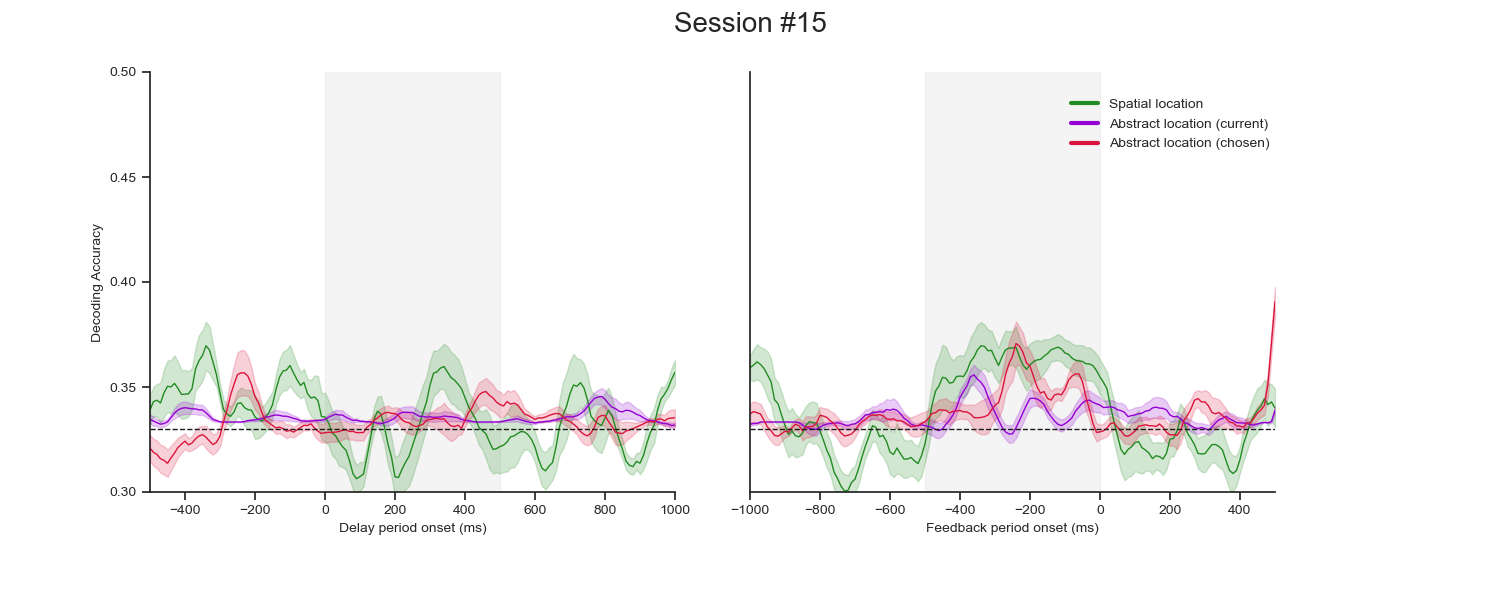

In [43]:
plt.close('all')
fig=plt.figure(figsize=(15,6),facecolor=(1, 1, 1))
gs = gridspec.GridSpec(1, 2) 

mean = np.convolve(accuracy.mean(axis=0),np.ones(5)/5,'same')
sem = np.convolve(accuracy.std(axis=0)/np.sqrt(accuracy.shape[0]),np.ones(5)/5,'same')

spatial_mean = np.convolve(spatial_accuracy.mean(axis=0),np.ones(5)/5,'same')
spatial_sem = np.convolve(spatial_accuracy.std(axis=0)/np.sqrt(spatial_accuracy.shape[0]),np.ones(5)/5,'same')

chosen_mean = np.convolve(chosen_accuracy.mean(axis=0),np.ones(5)/5,'same')
chosen_sem = np.convolve(chosen_accuracy.std(axis=0)/np.sqrt(chosen_accuracy.shape[0]),np.ones(5)/5,'same')

time = np.arange(-500,1001,10)
ind = np.arange(50,201)

ax = plt.subplot(gs[0])

ax.fill_between([0,500],[0,0],[1,1],color=[0.8,0.8,0.8],alpha=0.2)

ax.plot(time,spatial_mean[ind],color='forestgreen',lw=1)
ax.fill_between(time,spatial_mean[ind]-spatial_sem[ind],spatial_mean[ind]+spatial_sem[ind],
                color='forestgreen',alpha=0.2)

ax.plot(time,mean[ind],color='darkviolet',lw=1)
ax.fill_between(time,mean[ind]-sem[ind],mean[ind]+sem[ind],
                color='darkviolet',alpha=0.2)

ax.plot(time,chosen_mean[ind],color='crimson',lw=1)
ax.fill_between(time,chosen_mean[ind]-chosen_sem[ind],chosen_mean[ind]+chosen_sem[ind],
                color='crimson',alpha=0.2)

ax.plot([-500,1001],[0.33,0.33],'k--')
ax.set_ylim(0.3,0.5)
ax.set_yticks(np.linspace(0.3,0.5,5))
ax.set_xlim(-500,1000)
ax.set_xlabel('Delay period onset (ms)')
ax.set_ylabel('Decoding Accuracy')
ax.set_position([0.1,0.18,0.35,0.7])

time = np.arange(-1000,501,10)
ind = np.arange(201,352)

ax = plt.subplot(gs[1])

ax.fill_between([-500,0],[0,0],[1,1],color=[0.8,0.8,0.8],alpha=0.2)

ax.plot(time,spatial_mean[ind],color='forestgreen',lw=1)
ax.fill_between(time,spatial_mean[ind]-spatial_sem[ind],spatial_mean[ind]+spatial_sem[ind],
                color='forestgreen',alpha=0.2)

ax.plot(time,mean[ind],color='darkviolet',lw=1)
ax.fill_between(time,mean[ind]-sem[ind],mean[ind]+sem[ind],
                color='darkviolet',alpha=0.2)

ax.plot(time,chosen_mean[ind],color='crimson',lw=1)
ax.fill_between(time,chosen_mean[ind]-chosen_sem[ind],chosen_mean[ind]+chosen_sem[ind],
                color='crimson',alpha=0.2)

ax.plot([0,0],[0,0],color='forestgreen',lw=3,label='Spatial location')
ax.plot([0,0],[0,0],color='darkviolet',lw=3,label='Abstract location (current)')
ax.plot([0,0],[0,0],color='crimson',lw=3,label='Abstract location (chosen)')

ax.plot([-1000,501],[0.33,0.33],'k--')
ax.set_ylim(0.3,0.5)
ax.set_yticks([])
ax.set_xlim(-1000,500)
ax.set_xlabel('Feedback period onset (ms)')
ax.set_position([0.5,0.18,0.35,0.7])

plt.legend(frameon=False,loc=(0.6,0.8))
plt.suptitle('Session #15',fontsize=20)
plt.savefig('session'+str(ss)+'decoding accuracy.png',format = 'png')

In [33]:
def split_data(data, var1):
    
    """
    Half-split the experimental data for all the behavioral conditions defined by var1, var2, var3
    
    Args:
        data: pandas dataframe, has all the behavioral and neural data from a task;
              each row includes the spike counts of one neuron throughout different epochs within one trial,
              and the corresponding behavioral variables, and recording details from that trial.
        var1, var2: task variables
        
    Returns:
        train: one half of the data
        test: the other half
    
    """
    
    data.reset_index(inplace=True,drop=True)  
    cell_num = data.cellid.unique()
    kf = KFold(n_splits=2, shuffle=True)
    train_ind = np.array([])
    test_ind = np.array([])
    
    for var1_ind,val1 in enumerate(np.unique(data[var1])):  
        for var2_ind,val2 in enumerate(np.unique(data[var2])):
            for var3_ind,val3 in enumerate(np.unique(data[var3])):

                temp = data[(data[var1]==val1) & (data[var2]==val2) & (data[var3]==val3)]

                for c in range(cell_num.size):
                    
                    cData = temp[temp.cellid==cell_num[c]]
                    trialNum = np.array(cData.index)

                    c_train_ind, c_test_ind = list(kf.split(trialNum))[0]
                    train_ind = np.append(train_ind, trialNum[c_train_ind])
                    test_ind = np.append(test_ind, trialNum[c_test_ind])

    train = data.iloc[train_ind,:]
    test = data.iloc[test_ind,:]
    train.reset_index(inplace=True,drop=True)
    test.reset_index(inplace=True,drop=True)   
    
    return train, test


In [ ]:
def create_pseudotrial(data, var1, var2, var3='PreRwd', trialNum=100):
    
    """
    Generate psuedo-trials. Because most of the neurons were collected from separate sessions, here we resample the neural
    activity from individual neurons under the same behavioral condition and construct a population activity for one trial
    as if these neurons were recorded simultaneously. 
    
    Args:
        var1, var2: choice variable, 'Col' for target color or 'Loc' for target location
        res: residual sum of errors from function 'calculate_coef'
        
    Returns:
       A matrix of size Trials*Timestamps*Neurons + the corresponding labels of variables
    """
    
    cell_num = data.cellid.unique()
    pseudotrial = np.zeros([2,2,2,trialNum,ts,cell_num.size+3])  # number of unique values for var1, var2, var3 
    
    for var1_ind,val1 in enumerate(np.unique(data[var1])):  
        for var2_ind,val2 in enumerate(np.unique(data[var2])):
            for var3_ind,val3 in enumerate(np.unique(data[var3])):

                temp = data[(data[var1]==val1) & (data[var2]==val2) & (data[var3]==val3)]

                for c in range(cell_num.size):
                    
                    cData = temp[temp.cellid==cell_num[c]]
                    index = np.random.randint(cData.shape[0],size=trialNum)
                    c_pseudo = cData.iloc[index]
                    pseudotrial[var1_ind,var2_ind,var3_ind,:,:,c] = c_pseudo[c_pseudo.columns[-ts:]].to_numpy()

                pseudotrial[var1_ind,var2_ind,var3_ind,:,:,-3:] = [val1,val2,val1*val2]


    return pseudotrial.reshape((-1,ts,cell_num.size+3))


In [ ]:
def decoder_training(train, timestamps):
    
    """
    Apply linear support vector machine on the training data, and store the classifiers.
        
    """
    
    all_clf = [[] for x in range(len(timestamps))]

    for i, t in enumerate(timestamps):
        
        clf1 = SVC(kernel='linear')
        clf2 = SVC(kernel='linear')
        clf3 = SVC(kernel='linear')
        clf4 = SVC(kernel='linear',probability=True) 

        clf1.fit(train[:,t,:-3],train[:,t,-3])
        clf2.fit(train[:,t,:-3],train[:,t,-2])
        clf3.fit(train[:,t,:-3],train[:,t,-1])
        clf4.fit(train[:,t,:-3],train[:,t,-3]*2+train[:,t,-2])
        
        all_clf[i]=[clf1,clf2,clf3,clf4]
        
    return all_clf

In [ ]:
def decoder_predict(all_clf, test, timestamps):
    
    """
        
    Returns:
        Accuracy: decoding/classification accuracy for these 4 variables: 
                  current choice, previous choice, switch and choice history across two successive trials.
        Projection: the projection onto the encoding axis of each variable defined by SVM, one data point is one pseudo-trial
    
    """
    
    
    Accuracy = np.zeros((len(timestamps),5))
    Projection = np.zeros((len(timestamps),test.shape[0],7))

    for i, t in enumerate(timestamps):

        clf1=all_clf[i][0]
        clf2=all_clf[i][1]
        clf3=all_clf[i][2]
        clf4=all_clf[i][3]

        Accuracy[i,0] = accuracy_score(clf1.predict(test[:,t,:-3]),test[:,t,-3])
        Accuracy[i,1] = accuracy_score(clf2.predict(test[:,t,:-3]),test[:,t,-2])
        Accuracy[i,2] = accuracy_score(clf3.predict(test[:,t,:-3]),test[:,t,-1])
        Accuracy[i,3] = accuracy_score(clf4.predict(test[:,t,:-3]),test[:,t,-3]*2+test[:,t,-2])
        Accuracy[i,4] = t

        Projection[i,:,0] = test[:,t,-3]
        Projection[i,:,1] = test[:,t,-2]
        Projection[i,:,2] = test[:,t,-1]
        Projection[i,:,3] = np.ravel((np.dot(test[:,t,:-3],np.transpose(clf1.coef_))+clf1.intercept_)/LA.norm(clf1.coef_))
        Projection[i,:,4] = np.ravel((np.dot(test[:,t,:-3],np.transpose(clf2.coef_))+clf2.intercept_)/LA.norm(clf2.coef_))
        Projection[i,:,5] = np.ravel((np.dot(test[:,t,:-3],np.transpose(clf3.coef_))+clf3.intercept_)/LA.norm(clf3.coef_))
        Projection[i,:,6] = t
        
    return Accuracy, Projection

In [ ]:
def simulation_accuracy(data, var1, var2, regressors, timestamps, num_iter=10, trialNum=100):
    
    """
    Put all the functions above together, get the decoding accuracy and the projection for
    1) the experimental data, 
    2) simulation with the original regression coefficients,
    3) simulation with the switch signal removed. 
    
    """   
    
    Accuracy = np.zeros((3,num_iter,len(timestamps),6)) # first column, 0 is data, 1 is simulation, 2 is removal
    Projection = np.zeros((3,num_iter,len(timestamps),trialNum*8,8))

    for ii in range(num_iter):
    
        train_data, test_data = split_data(data, var1, var2)
        train_pseudotrial = create_pseudotrial(train_data, var1, var2, trialNum=trialNum)
        test_pseudotrial = create_pseudotrial(test_data, var1, var2, trialNum=trialNum)
        
        test_simulation_param = calculate_coef(test_data, regressors, timestamps)   
        test_simulation, _ = generate_data(test_data, test_simulation_param['coef'], test_simulation_param['res'], regressors, var1, timestamps)
        test_simulation_pseudotrial = create_pseudotrial(test_simulation, var1, var2, trialNum=trialNum)
        
        removal_coef = coef_manipulation(test_simulation_param['coef'], regressors, var1, 'Removal', 0, timestamps)
        test_removal,_ = generate_data(test_data, removal_coef, test_simulation_param['res'], regressors, var1, timestamps)
        test_removal_pseudotrial = create_pseudotrial(test_removal, var1, var2, trialNum=trialNum)
        
        all_clf = decoder_training(train_pseudotrial, timestamps)
        Accuracy[0,ii,:,:-1], Projection[0,ii,:,:,:-1] = decoder_predict(all_clf, test_pseudotrial, timestamps)
        Accuracy[1,ii,:,:-1], Projection[1,ii,:,:,:-1] = decoder_predict(all_clf, test_simulation_pseudotrial, timestamps)
        Accuracy[2,ii,:,:-1], Projection[2,ii,:,:,:-1] = decoder_predict(all_clf, test_removal_pseudotrial, timestamps)
        
    for jj in range(3):
        Accuracy[jj,:,:,-1]=jj
        Projection[jj,:,:,:,-1]=jj
                       
    
    Accuracy_df = pd.DataFrame(data=Accuracy.reshape(-1,6),columns=['Current','Previous','Switch','Choice Sequence','Time','Method'])
    Projection_df = pd.DataFrame(data=Projection.reshape(-1,8),columns=['Current','Previous','Switch','CurrentProjection',
                                                                        'PreviousProjection','SwitchProjection','Time','Method'])
    
    return Accuracy_df, Projection_df


In [ ]:
def plot_dataacc(accuracy,task):
    
    """
    Compare the decoding accuracy among three different testing datasets, as described above. 
    
    """    

    plt.close('all')
    fig, axs = plt.subplots(2, 4, figsize=(6,4),facecolor=(1, 1, 1))
    variables = ['Current','Previous','Switch','Choice Sequence']

    if task == 'PRL':
        ticklabels = ['0', '0.5', '1']
        ticks=[[2,4,6],[11,13,15]]
        tlim=[[-1,8],[8,17]]
    else:
        ticklabels = ['0', '0.5']
        ticks=[[2,4],[11,13]]
        tlim=[[0,7],[9,16]]
        
    ticksize=10
    titlesize=12

    for var in range(4):
        
        for ax_ind in range(2):
            
            ax=axs[int(np.floor(var/2)),ax_ind+2*(var%2)]
            sns.lineplot(accuracy[(accuracy.Time>tlim[ax_ind][0]) & (accuracy.Time<tlim[ax_ind][1])],
                         x='Time',y=variables[var],hue='Method',palette=['k','forestgreen','darkviolet'],
                         ax=ax,zorder=2,marker='o',markeredgecolor=None,legend=False)

            ax.set_xticks(ticks[ax_ind])
            ax.set_ylim(0,1.05)
            ax.set_xlim(tlim[ax_ind][0]+1,tlim[ax_ind][1]-1)
                
                
            if ax_ind == 0:

                ax.fill_between([2,4],[1,1],color=[0.6,0.6,0.6],alpha=0.15,edgecolor=None)
                ax.spines[['right', 'top']].set_visible(False)
                ax.set_xlabel('Target onset',fontsize=ticksize)
                    
                if var%2==0:
                    ax.set_ylabel('Accuracy (%)')
                else:
                    ax.set_ylabel('')
                    ax.set_yticklabels('')
                
            else:
                ax.fill_between([11,13],[1,1],color=[0.6,0.6,0.6],alpha=0.15,edgecolor=None)
                ax.spines[['left', 'right', 'top']].set_visible(False)
                ax.set_xlabel('Feedback onset',fontsize=ticksize)
                ax.set_ylabel('')
                ax.set_yticks([])
                
            if var == 3:
                ax.plot(np.array(tlim[ax_ind]),[0.25,0.25],'k--',zorder=1)
            else:
                ax.plot(np.array(tlim[ax_ind]),[0.5,0.5],'k--',zorder=1)     
                
            if var < 2:
                ax.set_xticklabels('')
                ax.set_xlabel('')
            else:
                ax.set_xticklabels(ticklabels,fontsize=ticksize)   
                
            ax.set_position([0.2+0.4*(var%2)+0.17*ax_ind,0.55-0.4*np.floor(var/2),0.15,0.3])
     
        ax.text(10,1.05,variables[var],fontsize=titlesize,ha='center')


    plt.suptitle(task,fontsize=titlesize)


In [ ]:
def plot_projection_dist(df,task,method):
    
    if task == 'PRL':
        xlim=[-5,5]
        ylim=[-5,5]
    else:
        xlim=[-30,30]
        ylim=[-10,10]
    
    plt.close('all')
    fig, axs = plt.subplots(2, 2, figsize=(8,8),facecolor=(1, 1, 1))

    ax=axs[0,1]
    ax.axis('off')

    ax=axs[1,0]
    sns.kdeplot(data=df,x='CurrentProjection',y='SwitchProjection',fill=True,thresh=0.5,
                 hue=df[['Current', 'Switch']].apply(tuple, axis=1),ax=ax,legend=False)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('Choice(t)')
    ax.set_ylabel('Switch')
    ax.set_position([0.2,0.2,0.5,0.5])

    ax=axs[0,0]
    sns.histplot(data=df,x='CurrentProjection',hue='Current',ax=ax,legend=False,
                stat='percent',bins=20,multiple='dodge',element='step')
    ax.set_xlim(xlim)
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_yticks([])
    ax.set_ylabel('')
    ax.spines[['left','bottom','right', 'top']].set_visible(False)
    ax.set_position([0.2,0.7,0.5,0.2])

    ax=axs[1,1]
    sns.histplot(data=df,y='SwitchProjection',hue='Switch',ax=ax,legend=False,
                stat='percent',bins=20,multiple='dodge',element='step')
    ax.set_ylim(ylim)
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_yticks([])
    ax.set_ylabel('')
    ax.spines[['left','bottom','right', 'top']].set_visible(False)
    ax.set_position([0.7,0.2,0.2,0.5])

    plt.suptitle(task+' '+method)
    plt.savefig(task+' '+method+' '+'Projection')

In [ ]:
MP_accuracy,MP_projection = simulation_accuracy(MP[MP.area==0],'Loc','PreLoc',MP_regressors,np.arange(18), num_iter=2)
plot_dataacc(MP_accuracy,'MP')

In [ ]:
plot_projection_dist(MP_projection[(MP_projection.Time==5)&(MP_projection.Method==0)],'MP', 'Data')